# **Sarcasm Detection** 
# **Assignment 11: Sequential NLP Project 2 - Sarcasm Detection**

## Package Version:
- tensorflow==2.2.0
- pandas==1.0.5
- numpy==1.18.5
- google==2.0.3

## Dataset

### Acknowledgement
Misra, Rishabh, and Prahal Arora. "Sarcasm Detection using Hybrid Neural Network." arXiv preprint arXiv:1908.07414 (2019).

**Required Files given in below link.**

https://drive.google.com/drive/folders/1xUnF35naPGU63xwRDVGc-DkZ3M8V5mMk

## **Making Necessary Imports**

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input, Flatten, GlobalMaxPool1D, SpatialDropout1D

from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors # Gensim contains word2vec models and processing tools
from gensim.scripts.glove2word2vec import glove2word2vec

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import binarize

from nltk import word_tokenize

from google.colab import drive

import re
import os
import nltk


import random
random.seed(0)
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__

'2.3.0'

## **Load Data (5 Marks)**

We are connecting to a google drive where the shortcuts to the data are stored

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
folder_path = ("/content/drive/My Drive/")
os.chdir(folder_path)

We can potentially use this code(part of the repository from where the dataset originates) to capture the data as an array of dictionaries. However, for our purpose we are putting it into a dataframe

In [4]:
#def parseJson(fname):
 #   for line in open(fname, 'r'):
  #      yield eval(line) ##NOT IN USE

### **Read data into dataframe**

In [5]:
data = pd.read_json(folder_path + '/Sarcasm_Headlines_Dataset.json', lines=True)
#data = list(parseJson(folder_path + '/Sarcasm_Headlines_Dataset.json'))

### **Explore Data**

In [6]:
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


We see three columns in the data, the article itself, the headline and the is_sarcastic column

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


No Nulls which makes our job easier

In [8]:
data.describe()

,is_sarcastic
count,26709.000000
mean,0.438953
std,0.496269
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Remaining Exploration/visualization is carried out post addition of headline length.

## **Drop `article_link` from dataset (5 Marks)**

In [9]:
data = data.drop("article_link", axis = 1)

In [10]:
data.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


## **Get length of each headline and add a column for that (5 Marks)**

#### **Adding length of sentence to dataset**

In [11]:
def update_headline(headline):
    return len(headline.split(" "))

data["length"] = data["headline"].apply(update_headline)
data.head()

,headline,is_sarcastic,length
0,former versace store clerk sues over secret 'b...,0,12
1,the 'roseanne' revival catches up to our thorn...,0,14
2,mom starting to fear son's web series closest ...,1,14
3,"boehner just wants wife to listen, not come up...",1,13
4,j.k. rowling wishes snape happy birthday in th...,0,11


#### **Explore Data (Continued)**

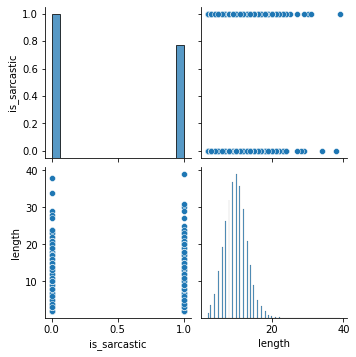

In [12]:
sns.pairplot(data)

The data is almost evenly split across sarcastic and non sarcastic across all lengths

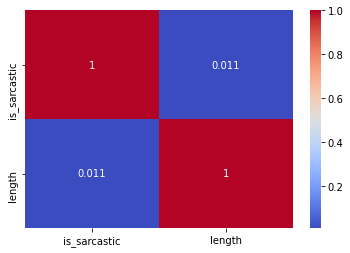

In [13]:
#changing data types to integers
data.is_sarcastic = data.is_sarcastic.astype(int)
data.headline_length = data.length.astype(int)

#generating heatmap
sns.heatmap(data.corr(), cmap='coolwarm', annot=True)

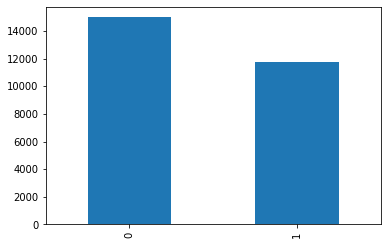

In [14]:
data["is_sarcastic"].value_counts().plot(kind = "bar")

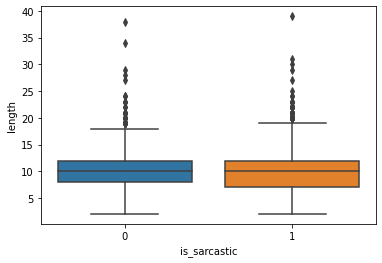

In [15]:
sns.boxplot(x='is_sarcastic', y='length', data=data)

As seen initially in the pair plot, this is a evenly split dataset across sarcastic, non_sarcastic categories. Numbers favor the non sarcastic posts marginally (which is fine)

### **Initialize parameter values**
- Set values for max_features, maxlen, & embedding_size
- max_features: Number of words to take from tokenizer(most frequent words)
- maxlen: Maximum length of each sentence to be limited to 25
- embedding_size: size of embedding vector

In [16]:
max_features = 10000
maxlen = 25
embedding_size = 200

### **Cleaning the headlines**

In [17]:
def update_headline(headline):
    headline_new = headline.lower()
    headline_new = re.sub('[^a-zA-z0-9\s]','',headline_new)
    headline_new = headline_new.replace('rt',' ')
    return headline_new

data["headline"] = data["headline"].apply(update_headline)
data.head()

,headline,is_sarcastic,length
0,former versace store clerk sues over secret bl...,0,12
1,the roseanne revival catches up to our thorny ...,0,14
2,mom sta ing to fear sons web series closest th...,1,14
3,boehner just wants wife to listen not come up ...,1,13
4,jk rowling wishes snape happy bi hday in the m...,0,11


## **Apply `tensorflow.keras` Tokenizer and get indices for words (5 Marks)**
- Initialize Tokenizer object with number of words as 10000
- Fit the tokenizer object on headline column
- Convert the text to sequence


### **Count Sarcastic vs Non Sarcastic**

In [18]:
print(len(data[ data['is_sarcastic'] == 1]))
print(len(data[ data['is_sarcastic'] == 0]))

11724
14985


### **Create/Seperate the features and the labels**

In [19]:
x = data['headline'].tolist()
y = data['is_sarcastic'].tolist()

In [20]:
x

['former versace store clerk sues over secret black code for minority shoppers',
 'the roseanne revival catches up to our thorny political mood for better and worse',
 'mom sta ing to fear sons web series closest thing she will have to grandchild',
 'boehner just wants wife to listen not come up with alternative debtreduction ideas',
 'jk rowling wishes snape happy bi hday in the most magical way',
 'advancing the worlds women',
 'the fascinating case for eating labgrown meat',
 'this ceo will send your kids to school if you work for his company',
 'top snake handler leaves sinking huckabee campaign',
 'fridays morning email inside trumps presser for the ages',
 'airline passengers tackle man who rushes cockpit in bomb threat',
 'facebook repo edly working on healthcare features and apps',
 'no h korea praises trump and urges us voters to reject dull hillary',
 'actually cnns jeffrey lord has been indefensible for a while',
 'barcelona holds huge protest in suppo  of refugees',
 'nucle

In [21]:
y

[0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,


### **Apply tokenizer and get words**
- We have already taken the headline into x. Plus it is inconvenient to apply tokenization on a DF series. So we use the list x to apply tokenization

In [22]:
vocabSize = max_features
tokenizer = Tokenizer(num_words=vocabSize, split=' ')
tokenizer.fit_on_texts(x)
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x,maxlen)

## **Pad sequences (5 Marks)**
- Pad each example with a maximum length
- Convert target column into numpy array

### **Padding to 25**

In [23]:
x = sequence.pad_sequences(x, maxlen=maxlen)
y = np.array(y)

In [24]:
x.shape

(26709, 25)

In [25]:
y

array([0, 0, 1, ..., 0, 0, 0])

### **Create train test split**

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

### **View shape of x_train, y_train**

In [27]:
x_train.shape

(21367, 25)

In [28]:
x_test.shape

(5342, 25)

### **Vocab mapping**
- There is no word for 0th index

In [29]:
tokenizer.word_index

{'to': 1,
 'of': 2,
 'the': 3,
 'in': 4,
 'for': 5,
 'a': 6,
 'on': 7,
 'and': 8,
 'with': 9,
 'is': 10,
 'new': 11,
 'trump': 12,
 'man': 13,
 'from': 14,
 'at': 15,
 'about': 16,
 'you': 17,
 'this': 18,
 'by': 19,
 'after': 20,
 'be': 21,
 'how': 22,
 'out': 23,
 'it': 24,
 'up': 25,
 'that': 26,
 'as': 27,
 'not': 28,
 'repo': 29,
 'are': 30,
 'your': 31,
 'what': 32,
 'his': 33,
 'he': 34,
 'just': 35,
 'who': 36,
 'us': 37,
 'has': 38,
 'will': 39,
 'no': 40,
 'more': 41,
 'all': 42,
 'into': 43,
 'one': 44,
 'why': 45,
 'have': 46,
 'area': 47,
 'over': 48,
 'donald': 49,
 'says': 50,
 'woman': 51,
 'can': 52,
 'day': 53,
 'its': 54,
 'her': 55,
 'time': 56,
 'first': 57,
 'like': 58,
 'pa': 59,
 'get': 60,
 'trumps': 61,
 'an': 62,
 'people': 63,
 'i': 64,
 'now': 65,
 'obama': 66,
 'house': 67,
 'h': 68,
 'off': 69,
 'life': 70,
 's': 71,
 'make': 72,
 'still': 73,
 'women': 74,
 'was': 75,
 'than': 76,
 'my': 77,
 'white': 78,
 'we': 79,
 'back': 80,
 'clinton': 81,
 'down': 

### **Set number of words (Size of Vocabulary)**
- Since the above 0th index doesn't have a word, add 1 to the length of the vocabulary

In [30]:
num_words = len(tokenizer.word_index) + 1
print(num_words)

28168


### **This is the size of the vocabulary -> 28168**

## **Load Glove Word Embeddings (5 Marks)**

In [31]:
path = '/content/drive/My Drive/'

glove_file = datapath(path + 'glove.6B.200d.txt') # This is a GloVe model
tmp_file = get_tmpfile(path + 'word2vec.glove.6B.200d.txt') #creating a tempfile for extraction


glove2word2vec(glove_file, tmp_file)  # Converting the GloVe file into a Word2Vec file
word2vec_model = KeyedVectors.load_word2vec_format(tmp_file)

### **Checking out the Glove Model**

In [32]:
wordEmbed = word2vec_model['cat']
print(wordEmbed.shape)
print(wordEmbed)

(200,)
[ 0.14823   -0.53152   -0.25973   -0.44095    0.38555   -0.4114
 -0.56649   -0.024739  -0.2788    -0.051034   0.3704    -0.20881
 -0.30809    0.3041    -0.3933    -0.18335   -0.59395    0.57039
 -0.16796    0.42368   -0.048687   0.95404    0.65675   -0.61759
  0.41923   -0.42904    0.2082    -0.33186   -0.0037637 -0.20592
  0.18708    0.06889   -0.28935   -0.7552     0.29278   -0.43407
  0.034869   0.081405  -0.14095   -0.34705    0.081686   0.40679
 -0.27834    0.93623   -0.63422    0.77979    0.29497   -0.14873
  0.5111     0.96405   -0.072559  -0.064779   0.20619   -0.46259
  0.49824   -0.40328   -0.92244    0.4663    -0.39433    0.64215
 -0.062508  -0.71985   -0.43478    0.34995   -0.6297    -0.21176
 -0.21179   -0.57816    0.84528    0.097692   0.22564   -0.2639
 -0.66842    0.40833   -0.35098   -0.67009   -0.55379   -0.10228
 -0.29934   -0.1074     0.14203    0.15513    0.39948   -0.42975
 -0.0077463 -0.21278    0.27161   -0.25162    0.41348   -0.72031
 -0.65133   -0.27737

In [33]:
word = 'apple'
if word in word2vec_model:
    print('{0} is in the model'.format(word))
else:
    print('{0} is NOT in the model'.format(word))

apple is in the model


In [34]:
print(word2vec_model.most_similar(positive=['apple']))

[('iphone', 0.6271389126777649), ('microsoft', 0.6061939001083374), ('intel', 0.5992331504821777), ('macintosh', 0.5989754796028137), ('ipod', 0.5908078551292419), ('ibm', 0.5888804793357849), ('ipad', 0.5876859426498413), ('software', 0.5711662769317627), ('google', 0.5554560422897339), ('itunes', 0.5478185415267944)]


In [35]:
print(word2vec_model.most_similar(positive=['microsoft', 'apple'], negative=['intel']))

[('software', 0.6169228553771973), ('google', 0.5910393595695496), ('aol', 0.572910487651825), ('itunes', 0.5522023439407349), ('netscape', 0.5507913827896118), ('browser', 0.5498033761978149), ('windows', 0.5322011113166809), ('users', 0.5299777388572693), ('iphone', 0.5295134782791138), ('internet', 0.5271527767181396)]


In [36]:
word2vec_model.similar_by_vector(word2vec_model['apple'] - word2vec_model['itunes'] + word2vec_model['microsoft'])

[('microsoft', 0.7563050389289856),
 ('apple', 0.6661206483840942),
 ('ibm', 0.6530752182006836),
 ('intel', 0.64974445104599),
 ('hewlett', 0.6136899590492249),
 ('packard', 0.5853277444839478),
 ('software', 0.5449655055999756),
 ('netscape', 0.537883996963501),
 ('oracle', 0.5367306470870972),
 ('compaq', 0.5244184732437134)]

### **Create embedding matrix**

In [37]:
EMBEDDING_FILE = './glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words, 200))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [38]:
embedding_matrix.shape

(28168, 200)

## **Define model (10 Marks)**
- Hint: Use Sequential model instance and then add Embedding layer, Bidirectional(LSTM) layer, flatten it, then dense and dropout layers as required. 
In the end add a final dense layer with sigmoid activation for binary classification.

In [39]:
#### Add your code here ####
model = Sequential() #adding sequential layer
model.add(Embedding(input_dim = max_features, output_dim = 100, input_length = maxlen)) #adding embedding layer 
model.add(SpatialDropout1D(0.4)) #added for robustness
model.add(Bidirectional(LSTM(units = 100, return_sequences = True, recurrent_dropout = 0.1))) #adding LSTM layer
model.add(Flatten())# Flatten 
#model.add(TimeDistributed(Dense(100, activation = "softmax"))) # timedistributed layer
# timedistributed layer removed as we have not been asked for it
model.add(Dense(33, activation = "relu")) # Dense layer
model.add(Dropout(0.2))
model.add(Dense(units=1,activation="sigmoid")) #Dense layer

In [40]:
#### Add your code here ####
model_pretrained = Sequential() #adding sequential layer
#we dont have a spatial layer here as it comes at a significant cost of accuracy
model_pretrained.add(Embedding(input_dim = num_words, weights=[embedding_matrix], output_dim = 200, input_length = maxlen, trainable=False)) #adding embedding layer 
model_pretrained.add(Bidirectional(LSTM(units = 100, return_sequences = True, recurrent_dropout = 0.2,))) #adding LSTM layer
model_pretrained.add(Flatten())# Flatten 
#model.add(TimeDistributed(Dense(100, activation = "softmax"))) 
# timedistributed layer removed as we have not been asked for it
model_pretrained.add(Dense(33, activation = "relu")) # Dense layer
model_pretrained.add(Dropout(0.2))
model_pretrained.add(Dense(units=1,activation="sigmoid")) #Dense layer

## **Compile the model (5 Marks)**

### **Creating 2 models, 1 for the pretrained embedding from the glove file, and 1 for non pre trained**

In [41]:
#### Add your code here ####
model.compile(optimizer= "adam", loss ="binary_crossentropy",metrics =["accuracy"])

In [42]:
model_pretrained.compile(optimizer= "adam", loss ="binary_crossentropy",metrics =["accuracy"])

In [43]:
#### Add your code here ####
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 100)           1000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 25, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 25, 200)           160800    
_________________________________________________________________
flatten (Flatten)            (None, 5000)              0         
_________________________________________________________________
dense (Dense)                (None, 33)                165033    
_________________________________________________________________
dropout (Dropout)            (None, 33)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

In [44]:
model_pretrained.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 200)           5633600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 25, 200)           240800    
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 33)                165033    
_________________________________________________________________
dropout_1 (Dropout)          (None, 33)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 34        
Total params: 6,039,467
Trainable params: 405,867
Non-trainable params: 5,633,600
______________________________________

## **Fit the model (5 Marks)**

### **Creating Early Stopping Callback**

In [45]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

### **Fitting the non pre-trained model**

In [46]:
#### Add your code here ####
fitted_model1 = model.fit(x_train, y_train, batch_size = 32, epochs=5, validation_split=0.3, verbose=1, callbacks = [es])

Epoch 1/5
468/468 [==============================] - 56s 119ms/step - loss: 0.4410 - accuracy: 0.7906 - val_loss: 0.3386 - val_accuracy: 0.8549
Epoch 2/5
468/468 [==============================] - 55s 118ms/step - loss: 0.2427 - accuracy: 0.9041 - val_loss: 0.3434 - val_accuracy: 0.8551
Epoch 00002: early stopping


### **Printing the layer by layer output**

In [47]:
count = 0
for l in model.layers:
    count = count + 1
    print ("Input to layer ", count, ": ", l.input)
    print ("Output from layer ", count, ": ", l.output)

Input to layer  1 :  Tensor("embedding_input:0", shape=(None, 25), dtype=float32)
Output from layer  1 :  Tensor("embedding/embedding_lookup/Identity_1:0", shape=(None, 25, 100), dtype=float32)
Input to layer  2 :  Tensor("embedding/embedding_lookup/Identity_1:0", shape=(None, 25, 100), dtype=float32)
Output from layer  2 :  Tensor("spatial_dropout1d/cond/Identity:0", shape=(None, 25, 100), dtype=float32)
Input to layer  3 :  Tensor("spatial_dropout1d/cond/Identity:0", shape=(None, 25, 100), dtype=float32)
Output from layer  3 :  Tensor("bidirectional/concat:0", shape=(None, 25, 200), dtype=float32)
Input to layer  4 :  Tensor("bidirectional/concat:0", shape=(None, 25, 200), dtype=float32)
Output from layer  4 :  Tensor("flatten/Reshape:0", shape=(None, 5000), dtype=float32)
Input to layer  5 :  Tensor("flatten/Reshape:0", shape=(None, 5000), dtype=float32)
Output from layer  5 :  Tensor("dense/Relu:0", shape=(None, 33), dtype=float32)
Input to layer  6 :  Tensor("dense/Relu:0", shape=

### **Check Model History to understand progress**

In [48]:
fitted_model1.history

{'accuracy': [0.7905856966972351, 0.9041187763214111],
 'loss': [0.4410315155982971, 0.24271517992019653],
 'val_accuracy': [0.8549368381500244, 0.8550928235054016],
 'val_loss': [0.3386043608188629, 0.3433974087238312]}

### **Visualize the accuracy plot**

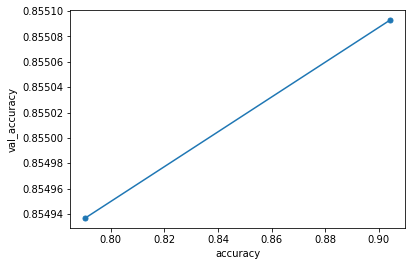

In [49]:
plt.xlabel("accuracy")
plt.ylabel("val_accuracy")
plt.plot(fitted_model1.history["accuracy"],fitted_model1.history["val_accuracy"], ls = "-", marker = ".", markersize = "10")

### **Fit the pretrained model**

In [50]:
#### Add your code here ####
fitted_model2 = model_pretrained.fit(x_train, y_train, batch_size = 32, epochs=5, validation_split=0.3, verbose=1, callbacks = [es])

Epoch 1/5
468/468 [==============================] - 51s 110ms/step - loss: 0.4937 - accuracy: 0.7621 - val_loss: 0.4208 - val_accuracy: 0.8053
Epoch 2/5
468/468 [==============================] - 51s 108ms/step - loss: 0.3459 - accuracy: 0.8485 - val_loss: 0.3575 - val_accuracy: 0.8439
Epoch 3/5
468/468 [==============================] - 51s 109ms/step - loss: 0.2737 - accuracy: 0.8870 - val_loss: 0.3905 - val_accuracy: 0.8284
Epoch 00003: early stopping


### **Printing the layer by layer output**

In [51]:
count = 0
for l in model_pretrained.layers:
    count = count + 1
    print ("Input to layer ", count, ": ", l.input)
    print ("Output from layer ", count, ": ", l.output)

Input to layer  1 :  Tensor("embedding_1_input:0", shape=(None, 25), dtype=float32)
Output from layer  1 :  Tensor("embedding_1/embedding_lookup/Identity_1:0", shape=(None, 25, 200), dtype=float32)
Input to layer  2 :  Tensor("embedding_1/embedding_lookup/Identity_1:0", shape=(None, 25, 200), dtype=float32)
Output from layer  2 :  Tensor("bidirectional_1/concat:0", shape=(None, 25, 200), dtype=float32)
Input to layer  3 :  Tensor("bidirectional_1/concat:0", shape=(None, 25, 200), dtype=float32)
Output from layer  3 :  Tensor("flatten_1/Reshape:0", shape=(None, 5000), dtype=float32)
Input to layer  4 :  Tensor("flatten_1/Reshape:0", shape=(None, 5000), dtype=float32)
Output from layer  4 :  Tensor("dense_2/Relu:0", shape=(None, 33), dtype=float32)
Input to layer  5 :  Tensor("dense_2/Relu:0", shape=(None, 33), dtype=float32)
Output from layer  5 :  Tensor("dropout_1/cond/Identity:0", shape=(None, 33), dtype=float32)
Input to layer  6 :  Tensor("dropout_1/cond/Identity:0", shape=(None, 3

### **Check Pre trained Model History to understand progress**

In [52]:
fitted_model2.history

{'accuracy': [0.7621021866798401, 0.8484889268875122, 0.8870018720626831],
 'loss': [0.4937100112438202, 0.34588202834129333, 0.27365052700042725],
 'val_accuracy': [0.8053345680236816, 0.8438621163368225, 0.8284199237823486],
 'val_loss': [0.420802503824234, 0.35754650831222534, 0.39050522446632385]}

### **Visualize the output**

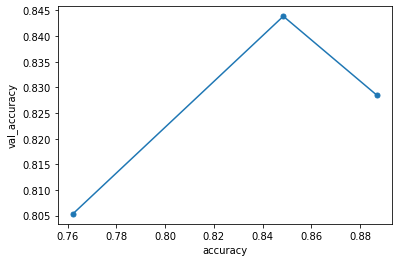

In [53]:
plt.xlabel("accuracy")
plt.ylabel("val_accuracy")
plt.plot(fitted_model2.history["accuracy"],fitted_model2.history["val_accuracy"], ls = "-", marker = ".", markersize = "10")

## **Evaluate and score the models**

In [54]:
#### Add your code here ####
score, acc = model.evaluate(x_test, y_test,verbose = 1)

167/167 [==============================] - 3s 16ms/step - loss: 0.3434 - accuracy: 0.8536


In [55]:
#### Add your code here ####
score1, acc1 = model_pretrained.evaluate(x_test, y_test,verbose = 1)

167/167 [==============================] - 3s 20ms/step - loss: 0.3668 - accuracy: 0.8420


In [56]:
print("score was", score, " accuracy was", acc)

score was 0.34338995814323425  accuracy was 0.8536128997802734


In [57]:
print("score was", score1, " accuracy was", acc1)

score was 0.3668050169944763  accuracy was 0.8420067429542542


The accuracies of both models are comparable. However, we saw a lower loss in the non pretrained model. 

### **Make the predictions for both models**

In [58]:
y_pred = model.predict(x_test)

In [59]:
y_pred_pretrained = model_pretrained.predict(x_test)

In [60]:
print(y_pred.shape)
print(y_pred_pretrained.shape)

(5342, 1)
(5342, 1)


In [61]:
y_pred

array([[0.19387889],
       [0.6597003 ],
       [0.7120677 ],
       ...,
       [0.02308303],
       [0.05400106],
       [0.00830638]], dtype=float32)

In [62]:
y_pred_pretrained

array([[0.03395334],
       [0.39011702],
       [0.4078194 ],
       ...,
       [0.08842075],
       [0.07385054],
       [0.30910298]], dtype=float32)

### **Binarizing the predictions**

In [63]:
y_pred_new = binarize(y_pred, 0.5)
y_pred_pretrained_new = binarize(y_pred_pretrained, 0.5)

In [64]:
y_pred_new = [item for sublist in y_pred_new for item in sublist]
y_pred_pretrained_new = [item for sublist in y_pred_pretrained_new for item in sublist]

In [65]:
y_pred_new = np.array(y_pred_new)
y_pred_pretrained_new = np.array(y_pred_pretrained_new)

### **Printing the classification report**

In [66]:
print(classification_report(y_test,y_pred_new))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      2972
           1       0.86      0.81      0.83      2370

    accuracy                           0.85      5342
   macro avg       0.85      0.85      0.85      5342
weighted avg       0.85      0.85      0.85      5342



In [67]:
print(classification_report(y_test,y_pred_pretrained_new))

              precision    recall  f1-score   support

           0       0.90      0.80      0.85      2972
           1       0.78      0.89      0.83      2370

    accuracy                           0.84      5342
   macro avg       0.84      0.85      0.84      5342
weighted avg       0.85      0.84      0.84      5342



### **Doing Sample Predictions**

In [68]:
sentiment_dict = dict({1:"Sarcastic",0:"Non Sarcastic"})

In [75]:
SAMPLE_INDEX = 44
p = model.predict(np.array([x_test[SAMPLE_INDEX]]))
p

array([[0.05938148]], dtype=float32)

In [76]:
if p > 0.5:
    print("Sarcastic")
else:
    print("Non Sarcastic")

Non Sarcastic


In [77]:
print(sentiment_dict.get(y_test[SAMPLE_INDEX]))

Non Sarcastic


In [72]:
SAMPLE_INDEX = 45
p = model_pretrained.predict(np.array([x_test[SAMPLE_INDEX]]))
p

array([[0.8142681]], dtype=float32)

In [73]:
if p > 0.5:
    print("Sarcastic")
else:
    print("Non Sarcastic")

Sarcastic


In [74]:
print(sentiment_dict.get(y_test[SAMPLE_INDEX]))

Sarcastic


# **Assignment 11 End**